This code is associated to the pre-print "Koopman ensembles for probabilistic time series forecasting", submitted to EUSIPCO 2024.

It enables you to:


*   Load and pre-process the Sentinel-2 data
*   Load the pre-trained ensembles
*   Evaluate the ensembles and compare their predictions on given pixels
*   Reproduce the figures of the pre-print



# Imports

In [1]:
import os
import shutil
import gdown
import numpy as np
import matplotlib.pyplot as plt
import random as rd
import copy as cp
from time import time

# import torch
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR, CosineAnnealingLR, ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torch import autograd
import torch.cuda
from torch.func import stack_module_state, vmap, functional_call
import gc

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

try :
  print(torch.cuda.get_device_name(0))
except :
  print("No GPU is available.")

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def mse_loss(x, x_hat):
    """
    Calculate the Mean Squared Error (MSE) loss between input and reconstructed data.

    Args:
        x (torch.Tensor): Input data.
        x_hat (torch.Tensor): Reconstructed data.

    Returns:
        torch.Tensor: Mean squared error loss.
    """
    total_prediction_loss = torch.sum((x-x_hat)**2)/(x.size()[0])
    return total_prediction_loss

def mL1_loss(x, x_hat):
  total_prediction_loss = torch.sum(torch.abs(x-x_hat))/(x.size()[0])
  return total_prediction_loss

def crps_ensemble(x, x_hat):
  """
    Calculate the Mean Squared Error (MSE) loss between input and reconstructed data.

    Args:
        x (numpy.array): Input data. Shape: (*)
        x_hat (numpy.array): Reconstructed data (with several ensemble members). Shape: (M, *)

    Returns:
        (numpy.array, numpy.array, numpy.array)
        The first value is the CRPS score, the second value is the mean absolute error (MAE),
        and the third is the halved mean absolute pairwise difference between ensemble member.
        The first value is equal to the second minus the third.
    """
  first_term = np.mean(np.abs(x - x_hat))
  second_term = 0
  for member in range(x.shape[0]):
    second_term += np.mean(np.abs(x[member] - x))
  return first_term - second_term / (2*(x.shape[0])), first_term, second_term / (2*(x.shape[0]))

cuda:0
Tesla T4


# Import data with gdown

Running the cell below enables you to download the Sentinel-2 data directly from Google Drive. Another option is to download the files from https://drive.google.com/drive/u/1/folders/1doHnjryCMptkzxYFfw-ILwAD0tOK3LGH and then use it as will, either locally or on a Google Colab session.

In [ ]:
# Fontainebleau interpolated time series
!gdown 1ZWH06EQYTiBUHRABVH2o_s2I_9Zm6dpo -O Fontainebleau_interpolated.npy

# Orléans irregular time series and its mask
!gdown 1K2QtxcJjnzCpPgBQnXrTyAM_yoyi2710 -O Orléans_irregular.npy
!gdown 17IjvRhWT4dzyr9vlKQOjoolYAzTvLfvF -O Orléans_mask.npy

In [ ]:
data = np.load('Fontainebleau_interpolated.npy')
max_Fontainebleau = np.max(data)

In [3]:
# We rescale the data to values between 0 and 1
if np.max(data) > 1:
  data /= max_Fontainebleau
  data *= 3 # Arbitrary rescaling and thresholding since the max is highly saturated
  data[data > 1] = 1

In [4]:
print(data.shape)
#343 -> temporal index ; 10 -> spectral band index ; 500, 500 -> spatial indexes

(343, 10, 500, 500)


In [ ]:
data_test = np.load('Orléans_irregular.npy')
mask_test = np.load('Orléans_mask.npy')

In [6]:
# We rescale the data to values between 0 and 1
if np.max(data_test) > 3:
  data_test /= max_Fontainebleau
  data_test *= 3 # Arbitrary rescaling since the max is highly saturated
  # This time we do not impose a threshold of 1

In [7]:
# We extract 100x100 squares out of the 500x500 pixel time series

data_small = data[:,:,250:350,250:350].transpose(0,2,3,1) #150x150
reflectances = data_small.transpose(3,1,2,0)

data_test_small = data_test[:,:,150:250,150:250].transpose(0,2,3,1) #150x150
print(data_test_small.shape)
reflectances_test = data_test_small.transpose(3,1,2,0)

(343, 100, 100, 10)


# Model

We introduce here a slight modification of the base class "KoopmanAE" in file "KoopmanAE.py".

We just changed the forward method in order to make predictions on several models in a convenient way with pytorch functional calls.
Also, K is now a linear layer with no bias, which is equivalent to its previous formulation as a tensor. The backward prediction feature has been removed for simplicity, although it may be re-implemented with little effort.

In [8]:
class KoopmanAE_member(torch.nn.Module):
    def __init__(self, input_dim:int, linear_dims:list, device='cpu'):
        """
        Koopman Autoencoder class, comprising an auto-encoder and a Koopman matrix.

        Args:
            input_dim (int): Dimension of the input data.
            linear_dims (list): List of linear layer dimensions.
            device (str, optional): Device to run the model on (default: 'cpu').
        """
        super(KoopmanAE_member, self).__init__()

        self.latent_dim = linear_dims[-1]

        # Encoder layers
        self.encoder = nn.ModuleList()
        self.encoder.add_module("encoder_1", nn.Linear(input_dim, linear_dims[0]))
        for i in range(len(linear_dims)-1):
            self.encoder.add_module(f"encoder_{i+2}", nn.Linear(linear_dims[i], linear_dims[i+1]))

        # Decoder layers
        self.decoder = nn.ModuleList()
        for i in range(len(linear_dims)-1):
            self.decoder.add_module(f"decoder_{i+1}", nn.Linear(linear_dims[-i-1], linear_dims[-i-2]))
        self.decoder.add_module(f"decoder_{len(linear_dims)}", nn.Linear(linear_dims[0], input_dim))

        # Koopman operator
        #self.K = torch.eye((self.latent_dim), requires_grad=True, device=device)
        self.K = nn.Linear(self.latent_dim, self.latent_dim, bias=False)
        torch.nn.init.eye_(self.K.weight)

    def forward(self, arguments):
        """
        An alias for forward_n_remember (practically useful with torch.func.functional_call)
        """
        x, n, to_decode, initial_encoding = arguments
        return self.forward_n_remember(x, n, to_decode, initial_encoding)

    def encode(self, x):
        """Encode input data x using the encoder layers."""
        for layer_idx, layer in enumerate(self.encoder):
            x = layer(x)
            if layer_idx < len(self.encoder) - 1:
                x = F.relu(x)
        return x

    def decode(self, x):
        """Decode the encoded data x using the decoder layers."""
        for layer_idx, layer in enumerate(self.decoder):
            x = layer(x)
            if layer_idx < len(self.decoder) - 1:
                x = F.relu(x)
        return x

    def one_step_ahead(self, x):
        """Predict one-step-ahead in the latent space using the Koopman operator."""
        return self.K(x)

    def forward_n(self, x, n):
        """
        Perform forward pass for n steps.

        Args:
            x (torch.Tensor): Input state.
            n (int): Number of steps to advance.

        Returns:
            x_advanced (torch.Tensor): Estimated state after n time steps.
            phi (torch.Tensor): Encoded input state.
            phi_advanced (torch.Tensor): Encoded state advanced by n time steps.
        """
        phi = self.encode(x)
        phi_advanced = self.one_step_ahead(phi)
        for k in range(n-1):
            phi_advanced = self.one_step_ahead(phi_advanced)
        x_advanced = self.decode(phi_advanced)
        return x_advanced, phi, phi_advanced

    def forward_n_remember(self, x, n, to_decode=None, initial_encoding=True):
        """
        Perform forward pass for n steps while remembering intermediate latent states.

        Args:
            x (torch.Tensor): Input state.
            n (int): Number of steps to advance.
            training (bool, optional): Flag to indicate training mode (default: False).

        Returns:
            x_advanced (torch.Tensor or None): Estimated state after n time steps if not training, otherwise None.
            phis (torch.Tensor): Encoded state at each step, concatenated along the 0th dimension.
        """
        phis = [self.encode(x)] if initial_encoding else [x]
        for k in range(n):
            phis.append(self.one_step_ahead(phis[-1]))
        phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis), dim=0)
        if to_decode is None:
          to_decode = n
        #print(to_decode)
        if to_decode == 'all':
          to_decode = [i for i in range(n+1)]
        x_advanced = self.decode(phis[to_decode]) if to_decode != [] else torch.zeros(1)
        return x_advanced, phis

    def configure_optimizers(self, lr=1e-3):
        """
        Configure the optimizer for training the model.

        Args:
            lr (float, optional): Learning rate for the optimizer (default: 1e-3).

        Returns:
            torch.optim.Optimizer: Optimizer instance.
        """
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        optimizer.add_param_group({"params": self.K})
        return optimizer

    def mse_loss(self, x, x_hat):
        """
        Calculate the Mean Squared Error (MSE) loss between input and reconstructed data.

        Args:
            x (torch.Tensor): Input data.
            x_hat (torch.Tensor): Reconstructed data.

        Returns:
            torch.Tensor: Mean squared error loss.
        """
        total_prediction_loss = torch.sum((x-x_hat)**2)/(x.size()[0])
        return total_prediction_loss

In [9]:
n_models = 8
latent_dim = 32
models = [KoopmanAE_member(20, [512,256,latent_dim], device=device).to(device) for i in range(n_models)]

# Import pre-trained models

In [10]:
!git clone https://github.com/anthony-frion/Sentinel2TS

Cloning into 'Sentinel2TS'...
remote: Enumerating objects: 176, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 176 (delta 1), reused 0 (delta 0), pack-reused 168
Receiving objects: 100% (176/176), 83.19 MiB | 23.64 MiB/s, done.
Resolving deltas: 100% (67/67), done.


In [11]:
%cd Sentinel2TS/ensembles

/content/Sentinel2TS/ensembles


# Evaluation on Fontainebleau

In [12]:
n_models = 8
latent_dim = 32
models = [KoopmanAE_member(20, [512,256,latent_dim], device=device).to(device) for i in range(n_models)]

lamda = 0 # Choose between 0, 0.1, 0.5, 0.9, 0.99 and 1
params = torch.load(f'trained_models/models_{lamda}.pt')

for model in range(len(models)):
  model_params = {}
  for key in params.keys():
    model_params[key] = params[key][model]
  models[model].load_state_dict(model_params)

params, buffers = stack_module_state(models)

# Construct a "stateless" version of one of the models. It is "stateless" in
# the sense that the parameters are meta Tensors and do not have storage.
base_model = cp.deepcopy(models[0])
base_model = base_model.to('meta')

def fmodel(params, buffers, x):
    return functional_call(base_model, (params, buffers), (x,))

In [13]:
starting_point = 0
ending_point = 342

whole_predictions = np.zeros((n_models,data_small.shape[0],data_small.shape[1],data_small.shape[2],data_small.shape[3]))
print(whole_predictions.shape, data_small.shape)

for column in range(data_small.shape[1]) :
  states = torch.Tensor(data_small[1:,column]).to(device)
  states = torch.cat([states, states - torch.Tensor(data_small[:-1,column]).to(device)], dim=2) # Add derivatives
  predictions, phis = vmap(fmodel, in_dims=(0, 0, None))(params, buffers,
                          (states[0], ending_point - starting_point - 1, "all", True))
  whole_predictions[:,starting_point+1:, column] = predictions.cpu().detach()[:,:,:,:10]

mean_predictions = np.mean(whole_predictions, axis=0)
print(whole_predictions.shape, mean_predictions.shape)

MSE_train = np.mean((data_small[starting_point+1:242] - whole_predictions[:,starting_point+1:242]) **2)
print(f"Mean squared error on training data (all members) : {MSE_train}")
MSE_test = np.mean((data_small[242:] - whole_predictions[:,242:]) **2)
print(f"Mean squared error on test data (all members) : {MSE_test}")
print()
MSE_train_mean = np.mean((data_small[starting_point+1:242] - mean_predictions[starting_point+1:242]) **2)
print(f"Mean squared error on training data (mean of members) : {MSE_train_mean}")
MSE_test_mean = np.mean((data_small[242:] - mean_predictions[242:]) **2)
print(f"Mean squared error on test data (mean of members) : {MSE_test_mean}")
print()
t0 = time()
CRPS_intra = crps_ensemble(whole_predictions[:,starting_point+1:242], data_small[starting_point+1:242])
CRPS_extra = crps_ensemble(whole_predictions[:,-100:], data_small[-100:])
# The CRPS score is the first value of the triplet.
print(f"CRPS on training period : {CRPS_intra}")
print(f"CRPS on validation period : {CRPS_extra}")
print(f"Time for computing CRPS: {round(time() - t0, 3)}s")

(8, 343, 100, 100, 10) (343, 100, 100, 10)
(8, 343, 100, 100, 10) (343, 100, 100, 10)
Mean squared error on training data (all members) : 0.001576105019949872
Mean squared error on test data (all members) : 0.002262175012618706

Mean squared error on training data (mean of members) : 0.0013902387728535442
Mean squared error on test data (mean of members) : 0.0020318868067701044

CRPS on training period : (0.018944556390359066, 0.0244702223615507, 0.005525665971191634)
CRPS on validation period : (0.024019330987789432, 0.03064784406133669, 0.006628513073547257)
Time for computing CRPS: 15.001s


(6, 0)
6


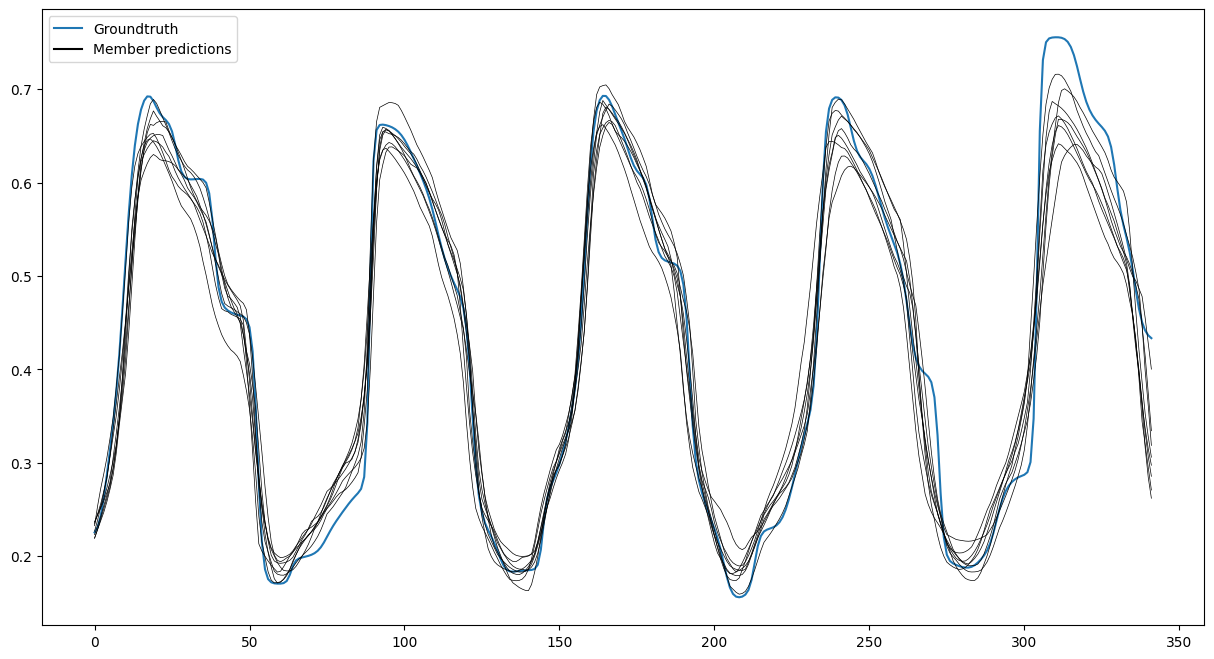

In [14]:
test_pixel = (rd.randint(0,99), rd.randint(0,99))
print(test_pixel)
band = 6
#band = rd.randint(0,9)
print(band)
#starting_point = 0

plt.figure(figsize=(15,8))
plt.plot(data_small[starting_point+1:, test_pixel[0], test_pixel[1], band], label='Groundtruth')
for member in range(n_models):
  plt.plot(whole_predictions[member, starting_point+1:, test_pixel[0], test_pixel[1], band], c='black', linewidth=.5)
plt.plot([], c='black', label='Member predictions')
plt.legend()

# Evaluation on Orléans

In [15]:
n_models = 8
latent_dim = 32
models = [KoopmanAE_member(20, [512,256,latent_dim], device=device).to(device) for i in range(n_models)]

lamda = 0 # Choose between 0, 0.1, 0.5, 0.9, 0.99 and 1
params = torch.load(f'trained_models/models_{lamda}.pt')

for model in range(len(models)):
  model_params = {}
  for key in params.keys():
    model_params[key] = params[key][model]
  models[model].load_state_dict(model_params)

params, buffers = stack_module_state(models)

# Construct a "stateless" version of one of the models. It is "stateless" in
# the sense that the parameters are meta Tensors and do not have storage.
base_model = cp.deepcopy(models[0])
base_model = base_model.to('meta')

def fmodel(params, buffers, x):
    return functional_call(base_model, (params, buffers), (x,))

In [16]:
# Guess the derivative from the second known image
second_date = np.argmax(mask_test[1:])+1
#initial_state_total = torch.Tensor(reflectances_test[:,:,:,0])
initial_state_total = torch.Tensor(reflectances_test[:,:,:,0])
initial_state_total = initial_state_total.to(device)
derivative = torch.Tensor(reflectances_test[:,:,:,second_date] - reflectances_test[:,:,:,0]) / second_date
initial_state_total = torch.cat((initial_state_total, derivative.to(device))).permute((1,2,0))
print(initial_state_total.shape)

torch.Size([100, 100, 20])


In [17]:
time_span = 342
initial_time = 0
whole_predictions = np.zeros((n_models, data_test_small.shape[0],data_test_small.shape[1],data_test_small.shape[2],10))
print(whole_predictions.shape, data_test_small.shape)

for column in range(data_test_small.shape[1]) :
  predictions, phis = vmap(fmodel, in_dims=(0, 0, None))(params, buffers,
                          (initial_state_total[column], time_span-initial_time, "all", True))
  #print(predictions.shape)
  whole_predictions[:,initial_time:, column] = predictions.cpu().detach()[:,:,:,:10]
mean_predictions = np.mean(whole_predictions, axis=0)
t0 = time()
MSE = torch.mean((torch.Tensor(data_test_small[initial_time:])[mask_test[initial_time:]==1] - whole_predictions[:,mask_test[initial_time:]==1]) **2)
MSE_intra = torch.mean((torch.Tensor(data_test_small[initial_time:])[:-100][mask_test[:-100]==1] - whole_predictions[:,:-100][:,mask_test[:-100]==1]) **2)
MSE_extra = torch.mean((torch.Tensor(data_test_small[initial_time:])[-100:][mask_test[-100:]==1] - whole_predictions[:,-100:][:,mask_test[-100:]==1]) **2)
print(f"Global MSE : {MSE}")
print(f"MSE on training period : {MSE_intra}")
print(f"MSE on validation period : {MSE_extra}")
print(f"Time for computing these 3 MSEs: {round(time() - t0, 3)}s")
print()
MSE_train_mean = torch.mean((torch.Tensor(data_test_small[initial_time:]) - mean_predictions)[:-100][mask_test[:-100]==1] **2)
print(f"Mean squared error on training data (mean of members) : {MSE_train_mean}")
MSE_test_mean = torch.mean((torch.Tensor(data_test_small[initial_time:]) - mean_predictions)[-100:][mask_test[-100:]==1] **2)
print(f"Mean squared error on test data (mean of members) : {MSE_test_mean}")
print()
t0 = time()
CRPS = crps_ensemble(whole_predictions[:,mask_test==1], data_test_small[mask_test==1])
CRPS_intra = crps_ensemble(whole_predictions[:,:-100][:,mask_test[:-100]==1], data_test_small[:-100][mask_test[:-100]==1])
CRPS_extra = crps_ensemble(whole_predictions[:,-100:][:,mask_test[-100:]==1], data_test_small[-100:][mask_test[-100:]==1])
print(f"Global CRPS : {CRPS}")
print(f"CRPS on training period : {CRPS_intra}")
print(f"CRPS on validation period : {CRPS_extra}")
print(f"Time for computing CRPS: {round(time() - t0, 3)}s")

(8, 343, 100, 100, 10) (343, 100, 100, 10)
Global MSE : 0.010135089779063826
MSE on training period : 0.009274249897991953
MSE on validation period : 0.011884538569629245
Time for computing these 3 MSEs: 1.253s

Mean squared error on training data (mean of members) : 0.008883077489017545
Mean squared error on test data (mean of members) : 0.01147785445114494

Global CRPS : (0.05556981659137667, 0.06382752725311337, 0.0082577106617367)
CRPS on training period : (0.05381798969095809, 0.0617507650161768, 0.007932775325218707)
CRPS on validation period : (0.059129980937388846, 0.06804804405721049, 0.008918063119821646)
Time for computing CRPS: 8.171s


(53, 16)
6


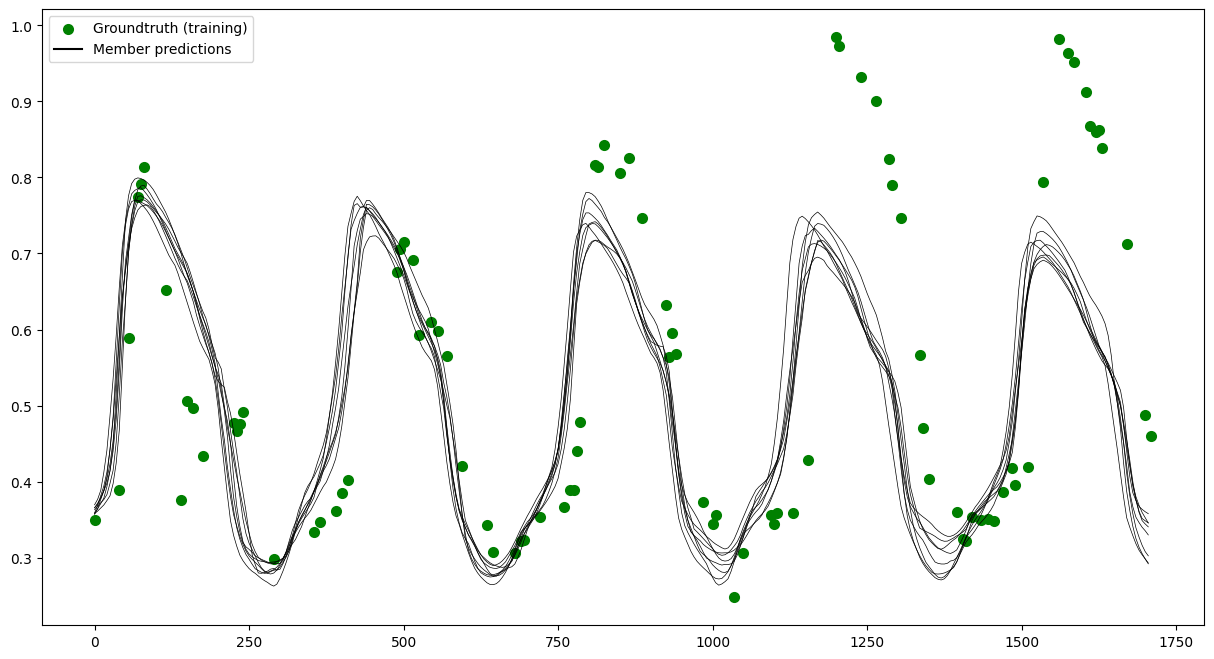

In [18]:
test_pixel = (rd.randint(0,99), rd.randint(0,99))
print(test_pixel)
band = 6
#band = rd.randint(0,9)
print(band)
#starting_point = 0
X = np.array([5*k for k in range(reflectances_test.shape[3])])
plt.figure(figsize=(15,8))
plt.scatter(X[mask_test[:time_span+2]==1], reflectances_test[band,test_pixel[0],test_pixel[1],:time_span+2][mask_test[:time_span+2]==1],
            c='green', linewidth=2, label='Groundtruth (training)')
for member in range(n_models):
  plt.plot(X[:time_span], whole_predictions[member, starting_point+1:, test_pixel[0], test_pixel[1], band], c='black', linewidth=.5)
plt.plot([], c='black', label='Member predictions')
plt.legend()

# Figures

In [19]:
def SSREL(nb_inds, X, Y):
  return sum([nb_inds[i] * abs(X[i] - Y[i]) if nb_inds[i] > 0 else 0 for i in range(len(X))]) / sum(nb_inds)

def SSRAT(std_predictions_flat, RMSE_flat):
  return np.mean(std_predictions_flat) / np.mean(RMSE_flat)

## Predictions for one pixel

(79, 20)
torch.Size([8, 342, 20])
torch.Size([8, 342, 20])


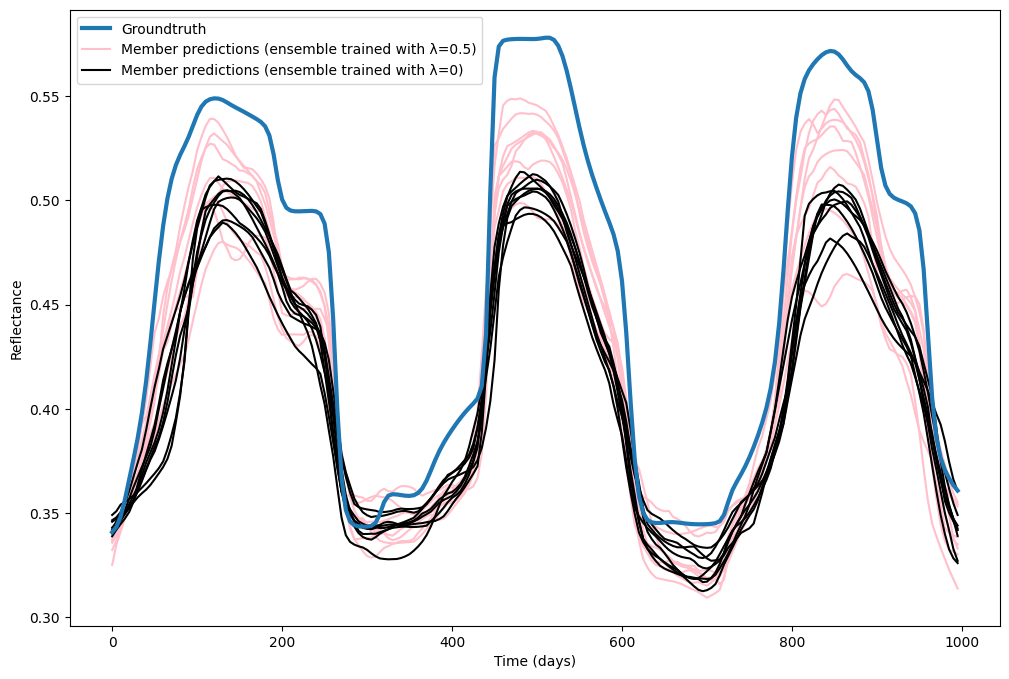

In [20]:
lambdas = [0.5, 0] # Choose between 0, 0.1, 0.5, 0.9, 0.99 and 1
colors = ['pink', 'black']


test_pixel = (79, 20) # The pixel in figure 1 from the preprint
#test_pixel = (rd.randint(0,99), rd.randint(0,99)) # Uncomment to show results for a random pixel
print(test_pixel)
band = 6
starting_point = 0
ending_point = 342

X = [5*k for k in range(data_small.shape[0]-1)]
Xlim = 200

plt.figure(figsize=(12,8))
plt.xlabel('Time (days)')
plt.ylabel('Reflectance')

for i in range(len(lambdas)):
  params = torch.load(f'trained_models/models_{lambdas[i]}.pt')

  for model in range(len(models)):
    model_params = {}
    for key in params.keys():
      model_params[key] = params[key][model]
    models[model].load_state_dict(model_params)

  params, buffers = stack_module_state(models)

  states = torch.Tensor(data_small[1:,test_pixel[0], test_pixel[1]]).to(device)
  states = torch.cat([states, states - torch.Tensor(data_small[:-1,test_pixel[0], test_pixel[1]]).to(device)], dim=1) # Add derivatives
  predictions, phis = vmap(fmodel, in_dims=(0, 0, None))(params, buffers,
                          (states[0], ending_point - starting_point - 1, "all", True))
  print(predictions.shape)
  for member in range(predictions.shape[0]):
    plt.plot(X[:Xlim], predictions[member,:Xlim,band].cpu().detach(), c=colors[i])
plt.plot(X[:Xlim], data_small[starting_point+1:Xlim+1, test_pixel[0], test_pixel[1], band], label='Groundtruth', linewidth=3)
for i in range(len(lambdas)):
  plt.plot([], [], c=colors[i], label=f'Member predictions (ensemble trained with λ={lambdas[i]})')
plt.legend()

(38,69), (79, 20)



## Spread-skill plots

### Fontainebleau

In [21]:
n_models = 8
latent_dim = 32
models = [KoopmanAE_member(20, [512,256,latent_dim], device=device).to(device) for i in range(n_models)]

lambdas = [0, 0.1, 0.5, 0.9, 0.99, 1]
RMSEs_flat, stds_predictions_flat = [], []

only_extrapolation = True # Choose wether to include all points or only extrapolated points in the diagram

for lamda in lambdas:
  params = torch.load(f'trained_models/models_{lamda}.pt')

  for model in range(len(models)):
    model_params = {}
    for key in params.keys():
      model_params[key] = params[key][model]
    models[model].load_state_dict(model_params)

  params, buffers = stack_module_state(models)

  data_smaller = data_small[:,:100,:100]
  starting_point = 0
  ending_point = 342

  whole_predictions = np.zeros((n_models,data_smaller.shape[0],data_smaller.shape[1],data_smaller.shape[2],data_smaller.shape[3]))
  print(whole_predictions.shape)

  for column in range(data_smaller.shape[1]) :
    states = torch.Tensor(data_smaller[1:,column]).to(device)
    states = torch.cat([states, states - torch.Tensor(data_smaller[:-1,column]).to(device)], dim=2) # Add derivatives
    predictions, phis = vmap(fmodel, in_dims=(0, 0, None))(params, buffers,
                            (states[0], ending_point - starting_point - 1, "all", True))
    whole_predictions[:,starting_point+1:, column] = predictions.cpu().detach()[:,:,:,:10]
  mean_predictions = np.mean(whole_predictions, axis=0, keepdims=True).squeeze(0)
  if only_extrapolation:
    squared_errors = (mean_predictions[-100:] - data_smaller[-100:]) **2
    std_predictions = np.std(whole_predictions[:,-100:], axis=0, keepdims=True).squeeze(0)
  else:
    squared_errors = (mean_predictions[1:] - data_smaller[1:]) **2
    std_predictions = np.std(whole_predictions[:,1:], axis=0, keepdims=True).squeeze(0)
  RMSE = np.sqrt(squared_errors)
  RMSE_flat = RMSE.flatten()
  std_predictions_flat = std_predictions.flatten()
  RMSEs_flat.append(np.copy(RMSE_flat))
  stds_predictions_flat.append(np.copy(std_predictions_flat))

(8, 343, 100, 100, 10)
(8, 343, 100, 100, 10)
(8, 343, 100, 100, 10)
(8, 343, 100, 100, 10)
(8, 343, 100, 100, 10)
(8, 343, 100, 100, 10)


In [23]:
print(np.max(stds_predictions_flat[0]))
max_std = np.max(stds_predictions_flat[0]).item()
bins = 20
X = [max_std*(bin+.5)/bins for bin in range(bins)]
Ys, nbs_inds = [], []
SSRELS, SSRATS = [], []
for i in range(len(lambdas)):
  print(f"Lambda = {lambdas[i]}")
  Y, nb_inds = [], []
  for bin in range(bins):
    RMSE_flat, std_predictions_flat = RMSEs_flat[i], stds_predictions_flat[i]
    inds = np.where((std_predictions_flat > max_std * (bin / bins)) & (std_predictions_flat <= max_std * ((bin+1) / bins)))
    mean_RMSE = np.mean(RMSE_flat[inds])
    Y.append(mean_RMSE)
    nb_inds.append(inds[0].shape[0])
  SSRELS.append(SSREL(nb_inds, X, Y))
  Y = np.array(Y)
  SSRATS.append(SSRAT(std_predictions_flat, RMSE_flat))
  nb_inds = np.array(nb_inds) / RMSE_flat.shape[0]
  Ys.append(Y)
  nbs_inds.append(nb_inds)
  #print(nb_inds)
  print(f"SSREL: {SSRELS[-1]}, SSRAT: {SSRATS[-1]}")

0.12335876339130136
Lambda = 0
SSREL: 0.01693355270234555, SSRAT: 0.41879147813937484
Lambda = 0.1


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


SSREL: 0.016246421170871123, SSRAT: 0.4433166608303305
Lambda = 0.5
SSREL: 0.010948498681186507, SSRAT: 0.6112692954558366
Lambda = 0.9
SSREL: 0.005500672150787379, SSRAT: 0.8337864491927245
Lambda = 0.99
SSREL: 0.003855585201597504, SSRAT: 1.0936566903137577
Lambda = 1
SSREL: 0.024667332487956644, SSRAT: 3.4773223626397223


### Orléans

In [24]:
RMSEs_flat, stds_predictions_flat = [], []

only_extrapolation = False # Choose wether to include all points or only extrapolated points in the diagram

for lamda in lambdas:
  params = torch.load(f'trained_models/models_{lamda}.pt')

  for model in range(len(models)):
    model_params = {}
    for key in params.keys():
      model_params[key] = params[key][model]
    models[model].load_state_dict(model_params)

  params, buffers = stack_module_state(models)

  data_test_small = data_test_small[:,:100,:100] # use the 100x100 square to match the spatial assimilation data
  reflectances_test = data_test_small.transpose(3,1,2,0)

  # Guess the derivative from the second known image
  second_date = np.argmax(mask_test[1:])+1
  #initial_state_total = torch.Tensor(reflectances_test[:,:,:,0])
  initial_state_total = torch.Tensor(reflectances_test[:,:,:,0])
  initial_state_total = initial_state_total.to(device)
  derivative = torch.Tensor(reflectances_test[:,:,:,second_date] - reflectances_test[:,:,:,0]) / second_date
  initial_state_total = torch.cat((initial_state_total, derivative.to(device))).permute((1,2,0))

  time_span = 342
  initial_time = 0
  whole_predictions = np.zeros((n_models, data_test_small.shape[0],data_test_small.shape[1],data_test_small.shape[2],10))
  print(whole_predictions.shape)

  for column in range(data_test_small.shape[1]) :
    predictions, phis = vmap(fmodel, in_dims=(0, 0, None))(params, buffers,
                            (initial_state_total[column], time_span-initial_time, "all", True))
    whole_predictions[:,initial_time:, column] = predictions.cpu().detach()[:,:,:,:10]
  mean_predictions = np.mean(whole_predictions, axis=0, keepdims=True).squeeze(0)
  if only_extrapolation:
    squared_errors = (mean_predictions - data_test_small)[-100:][mask_test[-100:]==1] **2
    std_predictions = np.std(whole_predictions, axis=0, keepdims=True).squeeze(0)[-100:][mask_test[-100:]==1]
  else:
    squared_errors = (mean_predictions - data_test_small)[mask_test==1] **2
    std_predictions = np.std(whole_predictions, axis=0, keepdims=True).squeeze(0)[mask_test==1]
  RMSE = np.sqrt(squared_errors)
  RMSE_flat = RMSE.flatten()
  std_predictions_flat = std_predictions.flatten()
  RMSEs_flat.append(np.copy(RMSE_flat))
  stds_predictions_flat.append(np.copy(std_predictions_flat))

(8, 343, 100, 100, 10)
(8, 343, 100, 100, 10)
(8, 343, 100, 100, 10)
(8, 343, 100, 100, 10)
(8, 343, 100, 100, 10)
(8, 343, 100, 100, 10)


In [25]:
print(np.max(stds_predictions_flat[0]))
max_std2 = np.max(stds_predictions_flat[0]).item()
bins = 20
X2 = [max_std2*(bin+.5)/bins for bin in range(bins)]
Ys2, nbs_inds2 = [], []
SSRELS2, SSRATS2 = [], []
for i in range(len(lambdas)):
  print(f"Lambda = {lambdas[i]}")
  Y2, nb_inds2 = [], []
  for bin in range(bins):
    RMSE_flat, std_predictions_flat = RMSEs_flat[i], stds_predictions_flat[i]
    inds = np.where((std_predictions_flat > max_std2 * (bin / bins)) & (std_predictions_flat <= max_std2 * ((bin+1) / bins)))
    mean_RMSE = np.mean(RMSE_flat[inds])
    Y2.append(mean_RMSE)
    nb_inds2.append(inds[0].shape[0])
  SSRELS2.append(SSREL(nb_inds2, X2, Y2))
  Y2 = np.array(Y2)
  SSRATS2.append(SSRAT(std_predictions_flat, RMSE_flat))
  nb_inds2 = np.array(nb_inds2) / RMSE_flat.shape[0]
  Ys2.append(Y2)
  nbs_inds2.append(nb_inds2)
  #print(nb_inds2)
  print(f"SSREL: {SSRELS2[-1]}, SSRAT: {SSRATS2[-1]}")

0.17709944744678774
Lambda = 0
SSREL: 0.047388891413009476, SSRAT: 0.24271336134933943
Lambda = 0.1
SSREL: 0.04751821608265339, SSRAT: 0.2516494494239635
Lambda = 0.5
SSREL: 0.03998891087634968, SSRAT: 0.3303373543215846
Lambda = 0.9
SSREL: 0.03363171371473898, SSRAT: 0.4661490502136966
Lambda = 0.99
SSREL: 0.018631262925392016, SSRAT: 0.7231209910186996
Lambda = 1
SSREL: 0.020200365729715723, SSRAT: 1.650751468253669


### Ensemble trained with proxy to CRPS

In [27]:
params = torch.load('trained_models/models_CRPS.pt')

for model in range(len(models)):
  model_params = {}
  for key in params.keys():
    model_params[key] = params[key][model]
  models[model].load_state_dict(model_params)

params, buffers = stack_module_state(models)

data_smaller = data_small[:,:100,:100]
starting_point = 0
ending_point = 342

whole_predictions = np.zeros((n_models,data_smaller.shape[0],data_smaller.shape[1],data_smaller.shape[2],data_smaller.shape[3]))
print(whole_predictions.shape)

for column in range(data_smaller.shape[1]) :
  states = torch.Tensor(data_smaller[1:,column]).to(device)
  states = torch.cat([states, states - torch.Tensor(data_smaller[:-1,column]).to(device)], dim=2) # Add derivatives
  predictions, phis = vmap(fmodel, in_dims=(0, 0, None))(params, buffers,
                          (states[0], ending_point - starting_point - 1, "all", True))
  whole_predictions[:,starting_point+1:, column] = predictions.cpu().detach()[:,:,:,:10]
mean_predictions = np.mean(whole_predictions, axis=0, keepdims=True).squeeze(0)
squared_errors = (mean_predictions[-100:] - data_smaller[-100:]) **2
std_predictions = np.std(whole_predictions[:,-100:], axis=0, keepdims=True).squeeze(0)
RMSE = np.sqrt(squared_errors)
RMSE_flat = RMSE.flatten()
std_predictions_flat = std_predictions.flatten()

bins = 20
X = [max_std*(bin+.5)/bins for bin in range(bins)]
Y_crps, nb_inds_crps = [], []
for bin in range(bins):
  inds = np.where((std_predictions_flat > max_std * (bin / bins)) & (std_predictions_flat <= max_std * ((bin+1) / bins)))
  mean_RMSE = np.mean(RMSE_flat[inds])
  Y_crps.append(mean_RMSE)
  #print(max_std, np.max(std_predictions_flat[0]).item(), max_std * ((bin+1) / bins))
  #print(inds[0].shape)
  nb_inds_crps.append(inds[0].shape[0])
SSREL_crps = SSREL(nb_inds_crps, X, Y_crps)
Y_crps = np.array(Y_crps)
SSRAT_crps = SSRAT(std_predictions_flat, RMSE_flat)
nb_inds_crps = np.array(nb_inds_crps) / RMSE_flat.shape[0]
print(nb_inds)
print(f"SSREL: {SSREL_crps}, SSRAT: {SSRAT_crps}")

(8, 343, 100, 100, 10)
[0.0032993 0.0658202 0.0974639 0.0734169 0.0680198 0.0626206 0.0510592
 0.0483441 0.0406425 0.0309856 0.0255734 0.0224324 0.0189938 0.0169988
 0.0163483 0.0158848 0.0153963 0.0148815 0.0139727 0.0130462]
SSREL: 0.008804669142695926, SSRAT: 0.7059952365201742


In [30]:
# Guess the derivative from the second known image
second_date = np.argmax(mask_test[1:])+1
#initial_state_total = torch.Tensor(reflectances_test[:,:,:,0])
initial_state_total = torch.Tensor(reflectances_test[:,:,:,0])
initial_state_total = initial_state_total.to(device)
derivative = torch.Tensor(reflectances_test[:,:,:,second_date] - reflectances_test[:,:,:,0]) / second_date
initial_state_total = torch.cat((initial_state_total, derivative.to(device))).permute((1,2,0))

time_span = 342
initial_time = 0
whole_predictions = np.zeros((n_models, data_test_small.shape[0],data_test_small.shape[1],data_test_small.shape[2],10))
print(whole_predictions.shape)

for column in range(data_test_small.shape[1]) :
  predictions, phis = vmap(fmodel, in_dims=(0, 0, None))(params, buffers,
                          (initial_state_total[column], time_span-initial_time, "all", True))
  whole_predictions[:,initial_time:, column] = predictions.cpu().detach()[:,:,:,:10]
mean_predictions = np.mean(whole_predictions, axis=0, keepdims=True).squeeze(0)
squared_errors = (mean_predictions - data_test_small)[mask_test==1] **2
std_predictions = np.std(whole_predictions, axis=0, keepdims=True).squeeze(0)[mask_test==1]
RMSE = np.sqrt(squared_errors)
RMSE_flat = RMSE.flatten()
std_predictions_flat = std_predictions.flatten()

X2 = [max_std2*(bin+.5)/bins for bin in range(bins)]
Y_crps_2, nb_inds_crps_2 = [], []
for bin in range(bins):
  inds = np.where((std_predictions_flat > max_std2 * (bin / bins)) & (std_predictions_flat <= max_std2 * ((bin+1) / bins)))
  mean_RMSE = np.mean(RMSE_flat[inds])
  Y_crps_2.append(mean_RMSE)
  nb_inds_crps_2.append(inds[0].shape[0])
SSREL_crps_2 = SSREL(nb_inds_crps_2, X2, Y_crps_2)
Y_crps_2 = np.array(Y_crps_2)
SSRAT_crps_2 = SSRAT(std_predictions_flat, RMSE_flat)
nb_inds_crps_2 = np.array(nb_inds_crps_2) / RMSE_flat.shape[0]
print(nb_inds_crps_2)
print(f"SSREL: {SSREL_crps_2}, SSRAT: {SSRAT_crps_2}")

(8, 343, 100, 100, 10)
[2.17168191e-01 2.48741809e-01 1.61788723e-01 1.22316702e-01
 8.19621277e-02 5.63094681e-02 3.89250000e-02 2.59503191e-02
 1.70623404e-02 1.13284043e-02 7.45659574e-03 4.75680851e-03
 2.96797872e-03 1.67351064e-03 8.60106383e-04 4.08829787e-04
 1.85851064e-04 8.14893617e-05 3.34042553e-05 1.52127660e-05]
SSREL: 0.03577275456312614, SSRAT: 0.4199205572204093


### Plot

<ipython-input-31-e39beb388b29>:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('Spread-skill_extrapolation_Fontainebleau.pdf')
<ipython-input-31-e39beb388b29>:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('Spread-skill_extrapolation_Fontainebleau.pdf')
<ipython-input-31-e39beb388b29>:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('Spread_skill_plots.pdf', bbox_inches='tight')
<ipython-input-31-e39beb388b29>:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('Spread_skill_plots.pdf', bbox_inches='tight')
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so r

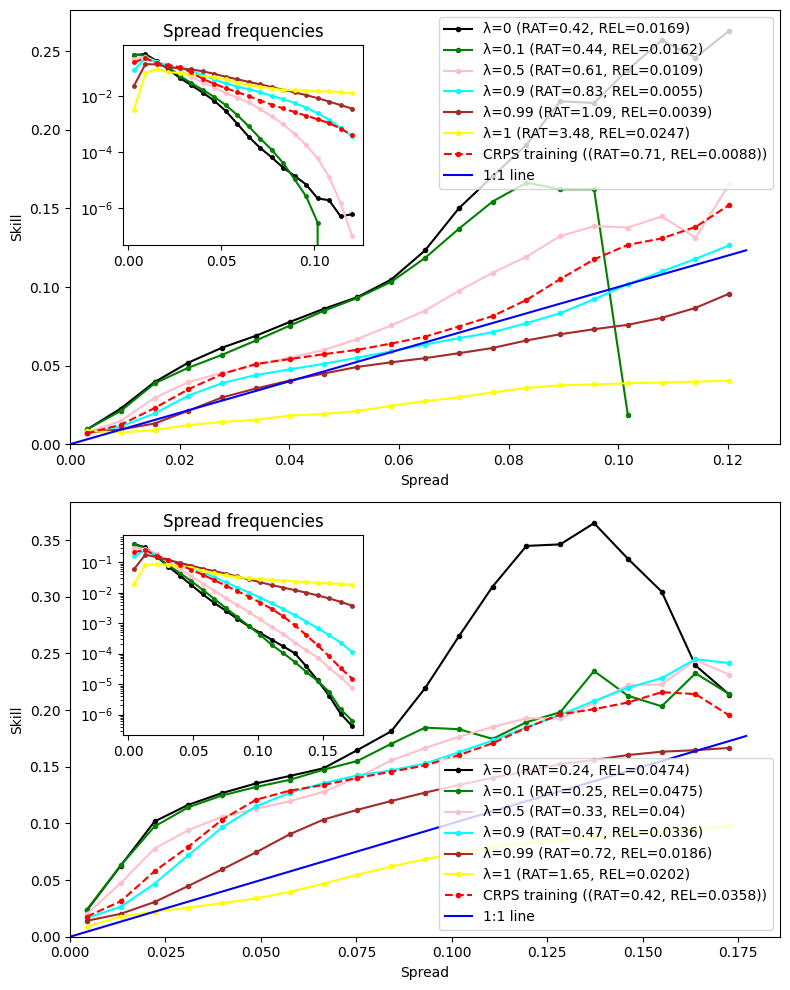

In [31]:
fig, (ax1, ax2) = plt.subplots(2,1, height_ratios=(1,1), figsize=(8,10))
fig.set_tight_layout(True)

ax1.set_xlim(0, 1.05*max_std)
ax1.set_ylim(0, 1.05*max([max(Y) for Y in Ys]))
ax1.set_xlabel('Spread')
ax1.set_ylabel('Skill')
colors = ['black', 'green', 'pink', 'cyan', 'brown', 'yellow', 'red']
for i in range(len(lambdas)):
  #plt.plot(X, Ys[i], c=colors[i], marker='.', label=f'λ={lambdas[i]}')
  ax1.plot(X, Ys[i], c=colors[i], marker='.', label=f'λ={lambdas[i]} (RAT={round(SSRATS[i],2)}, REL={round(SSRELS[i],4)})')
ax1.plot(X, Y_crps, c=colors[-1], marker='.', linestyle='--', label=f'CRPS training ((RAT={round(SSRAT_crps,2)}, REL={round(SSREL_crps,4)}))')
ax1.plot([0, max_std], [0, max_std], c='blue', label='1:1 line')
#plt.plot([0, max_std], [0, 2*max_std], c='blue')
left, bottom, width, height = [0.16, 0.75, 0.30, 0.20]
ax1.legend(loc='upper right')
ax12 = fig.add_axes([left, bottom, width, height])
for i in range(len(lambdas)):
  ax12.plot(X, nbs_inds[i], marker='.', markersize=5, c=colors[i])
ax12.plot(X, nb_inds_crps, marker='.', linestyle='--', markersize=5, c=colors[-1])
ax12.set_title('Spread frequencies')
ax12.set_yscale('log')
plt.savefig('Spread-skill_extrapolation_Fontainebleau.pdf')

ax2.set_xlim(0, 1.05*max_std2)
ax2.set_ylim(0, 1.05*max([max(Y) for Y in Ys2]))
ax2.set_xlabel('Spread')
ax2.set_ylabel('Skill')
for i in range(len(lambdas)):
  #plt.plot(X, Ys[i], c=colors[i], marker='.', label=f'λ={lambdas[i]}')
  ax2.plot(X2, Ys2[i], c=colors[i], marker='.', label=f'λ={lambdas[i]} (RAT={round(SSRATS2[i],2)}, REL={round(SSRELS2[i],4)})')
ax2.plot(X2, Y_crps_2, c=colors[-1], marker='.', linestyle='--', label=f'CRPS training ((RAT={round(SSRAT_crps_2,2)}, REL={round(SSREL_crps_2,4)}))')
ax2.plot([0, max_std2], [0, max_std2], c='blue', label='1:1 line')
ax2.legend(loc='lower right')
left, bottom, width, height = [0.16, 0.26, 0.30, 0.20]
ax22 = fig.add_axes([left, bottom, width, height])
for i in range(len(lambdas)):
  ax22.plot(X2, nbs_inds2[i], marker='.', markersize=5, c=colors[i])
ax22.plot(X2, nb_inds_crps_2, marker='.', linestyle='--', markersize=5, c=colors[-1])
ax22.set_title('Spread frequencies')
ax22.set_yscale('log')
plt.savefig('Spread_skill_plots.pdf', bbox_inches='tight')

### CRPS on both

In [32]:
lambdas = [0, 0.1, 0.5, 0.9, 0.99, 1]

CRPSs = []

only_extrapolation = True

for i, lamda in enumerate(lambdas):
  params = torch.load(f'trained_models/models_{lamda}.pt')

  for model in range(len(models)):
    model_params = {}
    for key in params.keys():
      model_params[key] = params[key][model]
    models[model].load_state_dict(model_params)

  params, buffers = stack_module_state(models)

  data_smaller = data_small[:,:100,:100]
  starting_point = 0
  ending_point = 342

  whole_predictions = np.zeros((n_models,data_smaller.shape[0],data_smaller.shape[1],data_smaller.shape[2],data_smaller.shape[3]))

  for column in range(data_smaller.shape[1]) :
    states = torch.Tensor(data_smaller[1:,column]).to(device)
    states = torch.cat([states, states - torch.Tensor(data_smaller[:-1,column]).to(device)], dim=2) # Add derivatives
    predictions, phis = vmap(fmodel, in_dims=(0, 0, None))(params, buffers,
                            (states[0], ending_point - starting_point - 1, "all", True))
    whole_predictions[:,starting_point+1:, column] = predictions.cpu().detach()[:,:,:,:10]
  if only_extrapolation:
    CRPS = crps_ensemble(whole_predictions[:,-100:], data_smaller[-100:])[0]
  else:
    CRPS = crps_ensemble(whole_predictions, data_smaller)[0]
  print(f"lambda={lambdas[i]}: CRPS={CRPS}")
  CRPSs.append(CRPS)

lambda=0: CRPS=0.024019330987789432
lambda=0.1: CRPS=0.023782853394759246
lambda=0.5: CRPS=0.021824648500985467
lambda=0.9: CRPS=0.022837196499447106
lambda=0.99: CRPS=0.024632660473717826
lambda=1: CRPS=0.0340583596857157


In [39]:
CRPSs2 = []

only_extrapolation = False

for i, lamda in enumerate(lambdas):
  params = torch.load(f'trained_models/models_{lamda}.pt')

  for model in range(len(models)):
    model_params = {}
    for key in params.keys():
      model_params[key] = params[key][model]
    models[model].load_state_dict(model_params)

  params, buffers = stack_module_state(models)

  # Guess the derivative from the second known image
  second_date = np.argmax(mask_test[1:])+1
  #initial_state_total = torch.Tensor(reflectances_test[:,:,:,0])
  initial_state_total = torch.Tensor(reflectances_test[:,:,:,0])
  initial_state_total = initial_state_total.to(device)
  derivative = torch.Tensor(reflectances_test[:,:,:,second_date] - reflectances_test[:,:,:,0]) / second_date
  initial_state_total = torch.cat((initial_state_total, derivative.to(device))).permute((1,2,0))

  time_span = 342
  initial_time = 0
  whole_predictions = np.zeros((n_models, data_test_small.shape[0],data_test_small.shape[1],data_test_small.shape[2],10))
  print(whole_predictions.shape)

  for column in range(data_test_small.shape[1]) :
    predictions, phis = vmap(fmodel, in_dims=(0, 0, None))(params, buffers,
                            (initial_state_total[column], time_span-initial_time, "all", True))
    whole_predictions[:,initial_time:, column] = predictions.cpu().detach()[:,:,:,:10]
  if only_extrapolation:
    CRPS = crps_ensemble(whole_predictions[:,mask_test==1], data_test_small[mask_test==1])[0]
  else:
    CRPS = crps_ensemble(whole_predictions[:,mask_test==1], data_test_small[mask_test==1])[0]
  print(f"lambda={lambdas[i]}: CRPS={CRPS}")
  CRPSs2.append(CRPS)

(8, 343, 100, 100, 10)
lambda=0: CRPS=0.05556981659137667
(8, 343, 100, 100, 10)
lambda=0.1: CRPS=0.05633230652537878
(8, 343, 100, 100, 10)
lambda=0.5: CRPS=0.05132982052946762
(8, 343, 100, 100, 10)
lambda=0.9: CRPS=0.05142275720998754
(8, 343, 100, 100, 10)
lambda=0.99: CRPS=0.05112955982515152
(8, 343, 100, 100, 10)
lambda=1: CRPS=0.055429947986545665


In [35]:
params = torch.load('trained_models/models_CRPS.pt')

for model in range(len(models)):
  model_params = {}
  for key in params.keys():
    model_params[key] = params[key][model]
  models[model].load_state_dict(model_params)

params, buffers = stack_module_state(models)

whole_predictions = np.zeros((n_models,data_smaller.shape[0],data_smaller.shape[1],data_smaller.shape[2],data_smaller.shape[3]))
print(whole_predictions.shape)

for column in range(data_smaller.shape[1]) :
  states = torch.Tensor(data_smaller[1:,column]).to(device)
  states = torch.cat([states, states - torch.Tensor(data_smaller[:-1,column]).to(device)], dim=2) # Add derivatives
  predictions, phis = vmap(fmodel, in_dims=(0, 0, None))(params, buffers,
                          (states[0], ending_point - starting_point - 1, "all", True))
  whole_predictions[:,starting_point+1:, column] = predictions.cpu().detach()[:,:,:,:10]
CRPS_crps = crps_ensemble(whole_predictions[:,-100:], data_smaller[-100:])[0]
print(CRPS_crps)

second_date = np.argmax(mask_test[1:])+1
#initial_state_total = torch.Tensor(reflectances_test[:,:,:,0])
initial_state_total = torch.Tensor(reflectances_test[:,:,:,0])
initial_state_total = initial_state_total.to(device)
derivative = torch.Tensor(reflectances_test[:,:,:,second_date] - reflectances_test[:,:,:,0]) / second_date
initial_state_total = torch.cat((initial_state_total, derivative.to(device))).permute((1,2,0))

time_span = 342
initial_time = 0
whole_predictions = np.zeros((n_models, data_test_small.shape[0],data_test_small.shape[1],data_test_small.shape[2],10))
print(whole_predictions.shape)

for column in range(data_test_small.shape[1]) :
  predictions, phis = vmap(fmodel, in_dims=(0, 0, None))(params, buffers,
                          (initial_state_total[column], time_span-initial_time, "all", True))
  whole_predictions[:,initial_time:, column] = predictions.cpu().detach()[:,:,:,:10]
CRPS_crps_2 = crps_ensemble(whole_predictions[:,mask_test==1], data_test_small[mask_test==1])[0]
print(CRPS_crps_2)

(8, 343, 100, 100, 10)
0.022775014735641676
(8, 343, 100, 100, 10)
0.051147968823294136


### Stuff

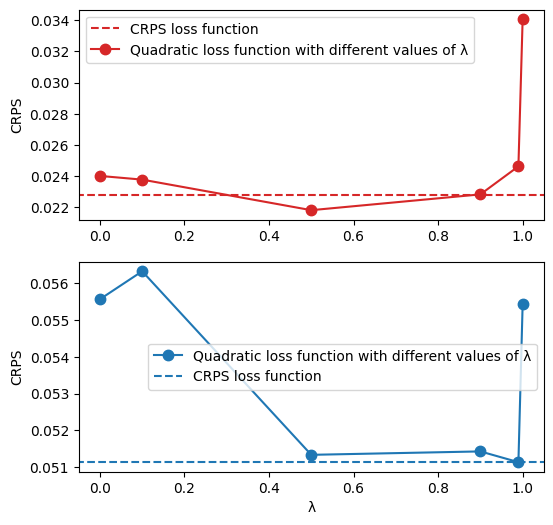

In [42]:
plt.figure(figsize=(6,6))
fig.set_tight_layout(True)
color = 'tab:red'
plt.subplot(211)
plt.ylabel('CRPS')
plt.axhline(CRPS_crps, -.1, 1.1, c=color, linestyle='--', label='CRPS loss function')
plt.plot(lambdas, CRPSs, marker='.', markersize=15, color=color, label='Quadratic loss function with different values of λ')
plt.legend()

plt.subplot(212)
color = 'tab:blue'
plt.ylabel('CRPS')
plt.xlabel('λ')
plt.plot(lambdas, CRPSs2,  marker='.', markersize=15, color=color, label='Quadratic loss function with different values of λ')
plt.axhline(CRPS_crps_2, -.1, 1.1, c=color, linestyle='--', label='CRPS loss function')
plt.legend()
plt.savefig('CRPS.pdf', bbox_inches='tight')